# Problem Definition

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. So we want to build a model to predict which tweets are disaster twets and which ones are not.

Available Data:
* id
* keyword: A keyword from that tweet (although this may be blank!)
* location: The location the tweet was sent from (may also be blank)
* text: The text of a tweet
* target: 1 if the tweet is a real disaster or 0 if not

# Exploration Data Analysis

### Importing Libararies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('ggplot')


import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


# Libraries for NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.utils import plot_model

#library for evaluations
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

# Loading pytorch packages.

import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

### Loading Data

In [113]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
#check missing data
df_train.isnull().sum()/len(df_train) 

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

### Explorating Target Variable

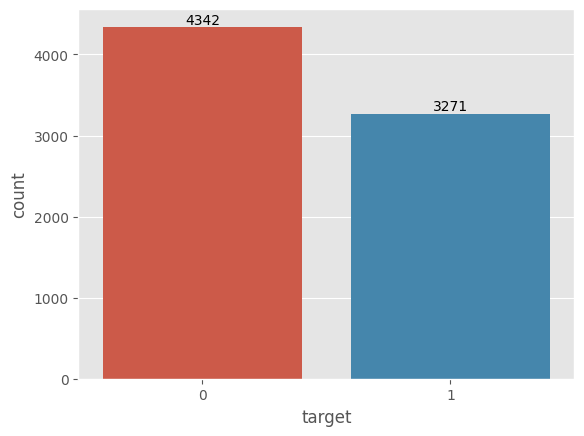

In [7]:
ax = sns.countplot(x ='target', data = df_train)
for label in ax.containers:
    ax.bar_label(label)
plt.show()

### Exploring Variables

#### What's the text length?

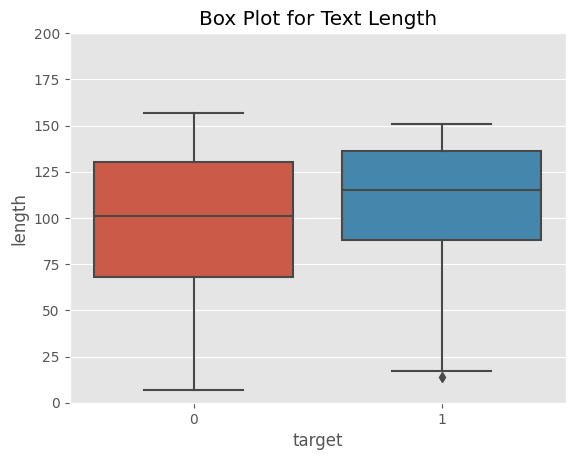

In [8]:
df_train['length'] = df_train['text'].apply(len)
sns.boxplot(x='target',y='length', data=df_train)
plt.ylim(0,200)
plt.title('Box Plot for Text Length')
plt.show()

### What's the number of words?

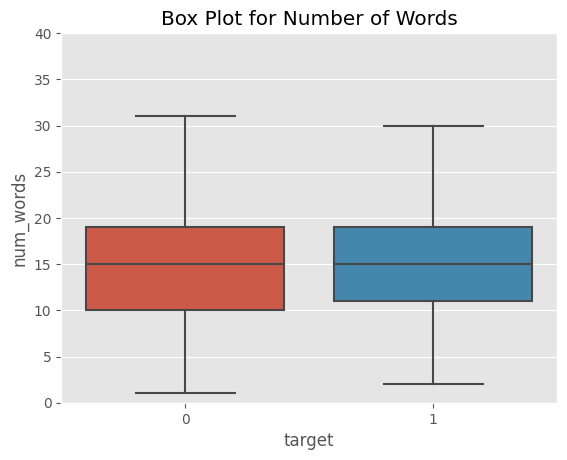

In [9]:
def count_words(x):
    return len(x.split())

df_train["num_words"] = df_train["text"].apply(count_words)
sns.boxplot(x='target',y='num_words', data=df_train)
plt.ylim(0,40)
plt.title('Box Plot for Number of Words')
plt.show()

#### What's the top 20 Keywords?

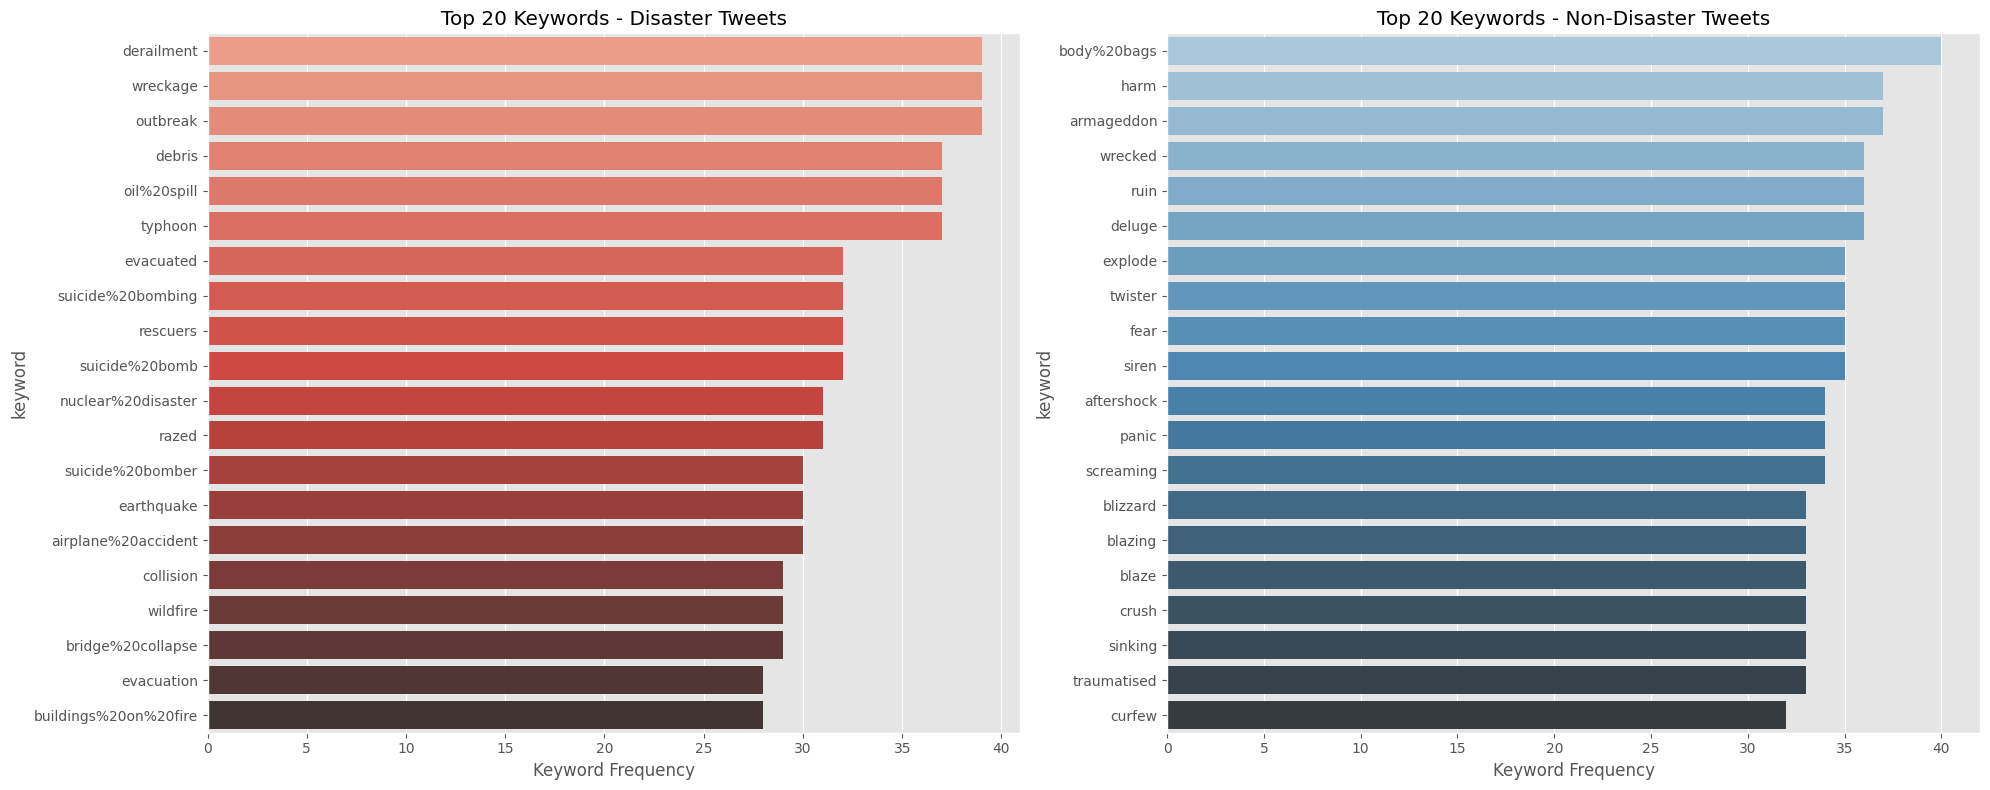

In [13]:
disaster_keywords = df_train.loc[df_train["target"] == 1]["keyword"].value_counts()
nondisaster_keywords = df_train.loc[df_train["target"] == 0]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_keywords[0:20].index, x=disaster_keywords[0:20], orient='h', ax=ax[0], palette="Reds_d")
ax[0].set_title("Top 20 Keywords - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")

sns.barplot(y=nondisaster_keywords[0:20].index, x=nondisaster_keywords[0:20], orient='h', ax=ax[1], palette="Blues_d")
ax[1].set_title("Top 20 Keywords - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")


plt.tight_layout()
plt.show()

#### What's the top 20 Locations?

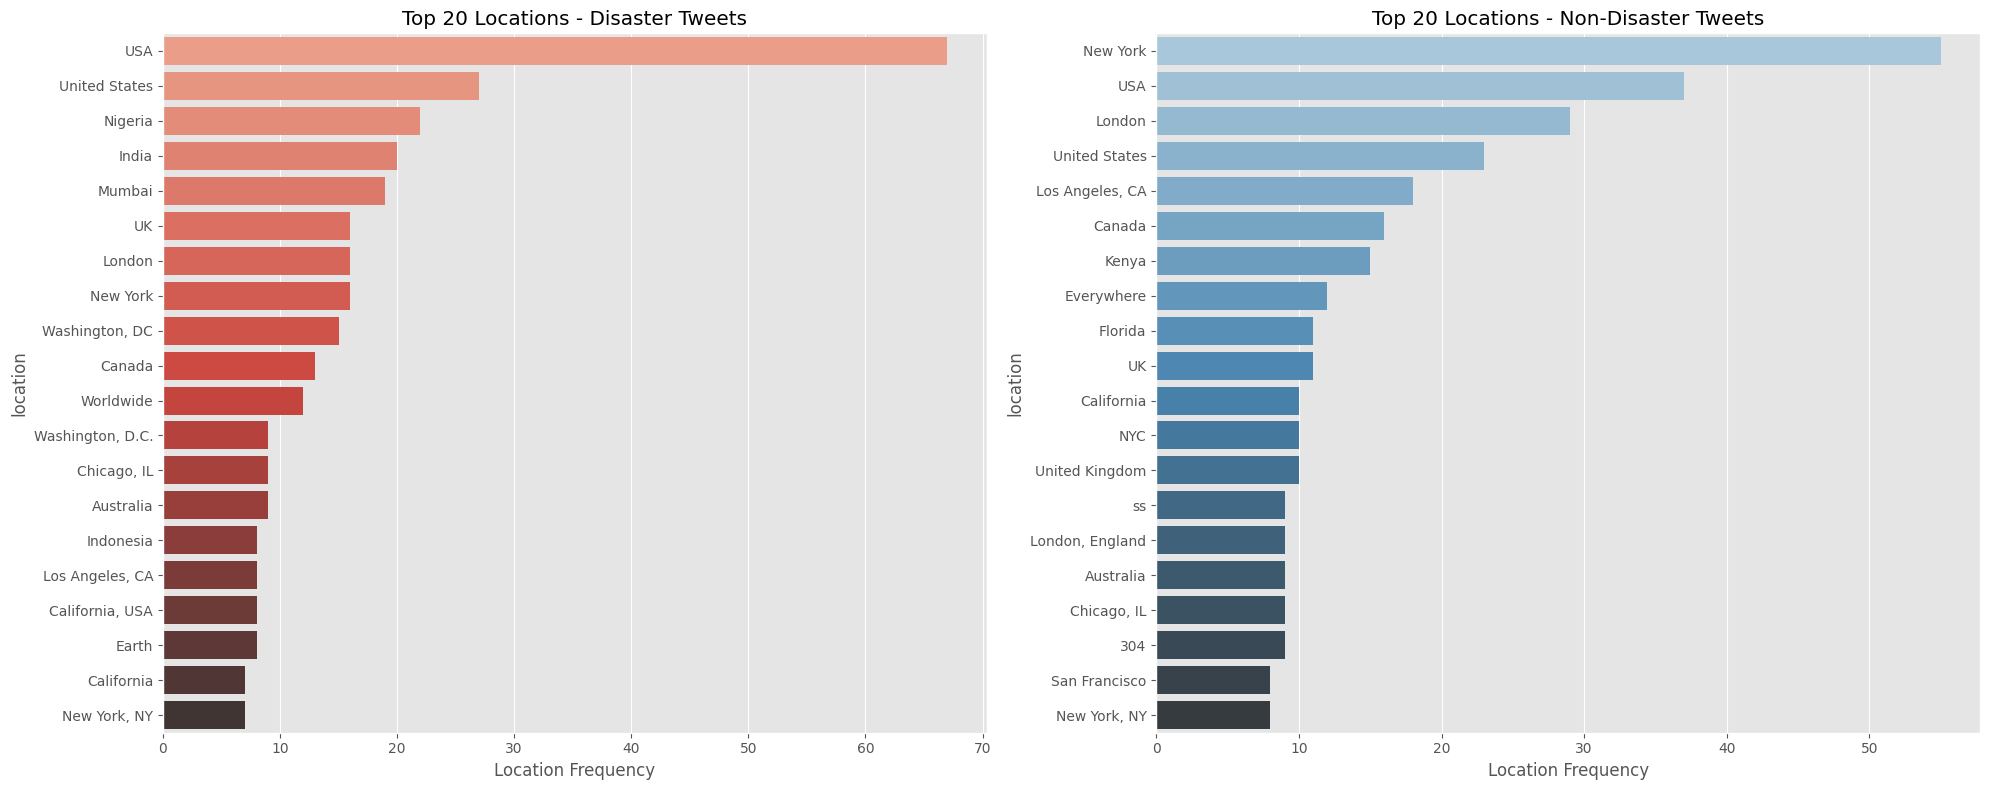

In [14]:
disaster_locations = df_train.loc[df_train["target"] == 1]["location"].value_counts()
nondisaster_locations = df_train.loc[df_train["target"] == 0]["location"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_locations[0:20].index, x=disaster_locations[0:20], orient='h', ax=ax[0], palette="Reds_d")
ax[0].set_title("Top 20 Locations - Disaster Tweets")
ax[0].set_xlabel("Location Frequency")

sns.barplot(y=nondisaster_locations[0:20].index, x=nondisaster_locations[0:20], orient='h', ax=ax[1], palette="Blues_d")
ax[1].set_title("Top 20 Locations - Non-Disaster Tweets")
ax[1].set_xlabel("Location Frequency")


plt.tight_layout()
plt.show()

#### WordCloud

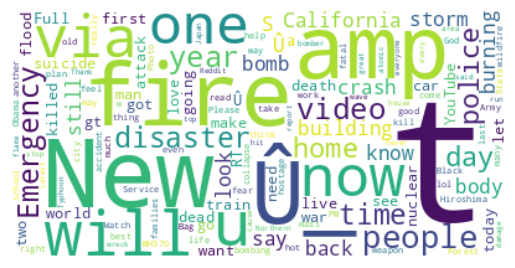

In [15]:
text = " ".join(df_train['text'])
stop_words = STOPWORDS.update(["https","co"]) #remove https from clouds
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white',stopwords=stop_words).generate(text)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Data Preprocessing

In [109]:
#remove urls
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
#remove html tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
#remove emoji
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
#remove punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text


#add more stopwords
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords
#stemming
stemmer = nltk.SnowballStemmer("english")

def data_preprocessing(text):
    text = text.lower() #lowercase
    text = remove_url(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = remove_punct(text)
    text = remove_not_ASCII(text)
     # Remove stopwords and Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' ') if word not in stop_words)
    return text

In [115]:
df_train['text_cleaned']=df_train['text'].apply(data_preprocessing)

#### Splitting into Train and Validation dataset

In [117]:
from sklearn.model_selection import train_test_split
df_train_cleaned = df_train[['text_cleaned','target']]
train, test = train_test_split(df_train_cleaned, test_size=0.33, random_state=15)
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)
print(f'Number of training tweets: {train.shape[0]}\n')
print(f'Number of testing tweets: {test.shape[0]}\n')

Number of training tweets: 5100

Number of testing tweets: 2513



In [28]:
train.head()

,text_cleaned,target
0,5000 year old ring fort demolish,0
1,f496d mhtw4fnet\n\npakistan say armi helicopt ...,1
2,char remain home 2nd st manchest nh fire rip 2...,1
3,new post prysmian secur contract blight bank w...,0
4,creelyou must think real moron flag man brainl...,0


In [118]:
test.head()

,text_cleaned,target
0,latest home raze northern california wildfir ...,1
1,crazi phone much damag person,0
2,twelv fear kill pakistani air ambul helicopt c...,1
3,histor flood across asia leav hundr dead milli...,1
4,kid disappear dust storm atmospher aussi thril...,1


# Models

### LSTM

In [78]:
#Tokenizer
#use this is in LSTM input is provided by embedding layer, which requires input data to be integer encoded
def X_tokenizer(df):
    max_features=3000
    tokenizer=Tokenizer(num_words=max_features,split=' ') #num_words can be used to restrict number of the token to considered by the model
    tokenizer.fit_on_texts(df['text_cleaned'].values) #updates internal vocabulary based on a list of texts. It will create a dictionary with word mapping with an index(unique numerical value)
    X = tokenizer.texts_to_sequences(df['text_cleaned'].values) #transforms each text in texts to a sequence of numerical value. It will give assign the index of each to the word. The output will be series of numerical values.
    X = pad_sequences(X)
    return X
    #We are not be having the same length for all the sentences and while providing input to neural networks, we should have the same dimension for all inputs. So pad_sequence() is used to pad the input so that all the inputs have the same dimension. It will add zeros to the input, in the beginning, to make sure all the inputs have the same dimension.

In [89]:
def LSTM_model():
    embed_dim = 32
    lstm_out = 32
    model_lstm = Sequential()
    model_lstm.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4))
    model_lstm.add(Dense(1,activation='sigmoid'))
    adam = optimizers.Adam(learning_rate=0.002)
    model_lstm.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
    return model_lstm

* Activation Function of Dense layer, i.e, is output layer is taken as Sigmoid function is taken as it is good at binary classification and our target column have value either 0 or 1.

* Dropout : It is added to avoid overfitting.

* Loss Function : The cross-entropy loss function is an optimization function that is used in the case of training a classification model and binary_crossentropy function computes the cross-entropy loss between true labels and predicted labels.

* Optimizer : Adam is used as optimizer which is replacement optimization algorithm for stochastic gradient descent for training deep learning models. Default learning rate of Adam is 0.001, but here I have initialized it to 0.002.

In [119]:
X = X_tokenizer(df_train_cleaned)
y = df_train_cleaned['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=15)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

5100 5100
2513 2513


In [120]:
model_lstm = LSTM_model()
print (model_lstm.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 21, 32)            96000     
                                                                 
 dropout_12 (Dropout)        (None, 21, 32)            0         
                                                                 
 lstm_12 (LSTM)              (None, 32)                8320      
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
None


In [121]:
res = model_lstm.fit(X_train,y_train, epochs = 7, batch_size = 32, validation_data = [X_test, y_test])

Epoch 1/7
160/160 [==============================] - 6s 21ms/step - loss: 0.5439 - accuracy: 0.7227 - val_loss: 0.4677 - val_accuracy: 0.7907
Epoch 2/7
160/160 [==============================] - 3s 19ms/step - loss: 0.3574 - accuracy: 0.8506 - val_loss: 0.4828 - val_accuracy: 0.7907
Epoch 3/7
160/160 [==============================] - 3s 19ms/step - loss: 0.2964 - accuracy: 0.8839 - val_loss: 0.5323 - val_accuracy: 0.7831
Epoch 4/7
160/160 [==============================] - 3s 19ms/step - loss: 0.2534 - accuracy: 0.8980 - val_loss: 0.5965 - val_accuracy: 0.7692
Epoch 5/7
160/160 [==============================] - 3s 19ms/step - loss: 0.2194 - accuracy: 0.9104 - val_loss: 0.6737 - val_accuracy: 0.7541
Epoch 6/7
160/160 [==============================] - 3s 18ms/step - loss: 0.1944 - accuracy: 0.9222 - val_loss: 0.7631 - val_accuracy: 0.7620
Epoch 7/7
160/160 [==============================] - 3s 18ms/step - loss: 0.1696 - accuracy: 0.9304 - val_loss: 0.8220 - val_accuracy: 0.7429


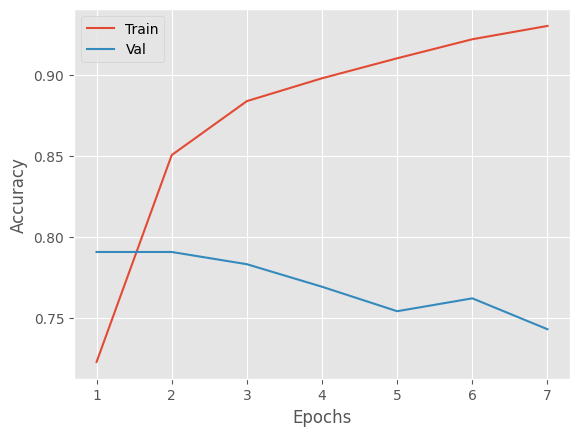

In [122]:
def plot_learning_curve(history,epochs):
    epoch_range = range(1,epochs+1)
    plt.plot(epoch_range,history.history['accuracy'])
    plt.plot(epoch_range,history.history["val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train","Val"],loc ="upper left")
    plt.show()
    
plot_learning_curve(res,7)

In [123]:
def show_metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
    
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [124]:
#predictions
y_pred_lstm = model_lstm.predict(X_test).round()

79/79 [==============================] - 1s 3ms/step


In [125]:
print(classification_report(y_test, y_pred_lstm))

              precision    recall  f1-score   support

           0       0.77      0.78      0.77      1430
           1       0.70      0.70      0.70      1083

    accuracy                           0.74      2513
   macro avg       0.74      0.74      0.74      2513
weighted avg       0.74      0.74      0.74      2513



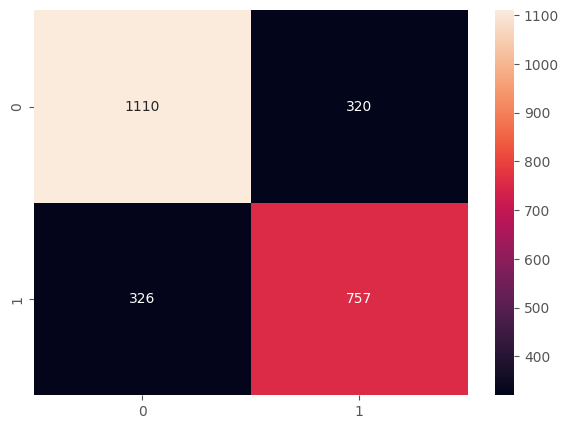

In [145]:
from sklearn.metrics import confusion_matrix
conm = confusion_matrix(y_test,y_pred_lstm)
plt.figure(figsize=(7, 5))
sns.heatmap(conm, annot=True, fmt='d')
plt.show()

## Bert Model

#### Tokenization and Formatting the Inputs

In [128]:
labels = train['target'].values
idx = len(labels)
tweets= train.text_cleaned.values
max_len = 0
for text in tweets: 
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Max sentence length:  52


In [137]:
num_labels = 2
epochs=2
batch_size=32,
model_name="bert-base-uncased"
max_sequence_length=52
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [131]:
def encode(data, tokenizer):
    input_ids = []
    attention_mask = []
    for text in data:
        #encode_plus is to split the sentence into tokens, then add special tokens for classification CLS
        tokenized_text = tokenizer.encode_plus(text,
                                            max_length=max_sequence_length, #Max length according our cleaned text data
                                            add_special_tokens =True, #Add CLS and SEP
                                            truncation = 'longest_first', #Activate and control truncation
                                            pad_to_max_length = True, #Pad % truncate all sentences to make sure they shared the same length
                                            return_attention_mask=True, #construct attention mask
                                            return_tensors = 'pt'     # Return pytorch tensors.
                                              )
        input_ids.append(tokenized_text['input_ids'])
        attention_mask.append(tokenized_text['attention_mask']) #Attention mask which is consisting of 1 and 0 for differentiate
    #convert the lists into tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_mask = torch.cat(attention_mask, dim=0) 
    return input_ids, attention_mask

In [134]:
def get_batches(df, tokenizer, batch_size=batch_size):
    x = list(df['text_cleaned'].values)
    labels = torch.tensor(df['target'].values)
    input_ids, attention_mask = encode(x, tokenizer)
    tensor_dataset = torch.utils.data.TensorDataset(input_ids, attention_mask, labels)
    tensor_randomsampler = torch.utils.data.RandomSampler(tensor_dataset)
    tensor_dataloader = torch.utils.data.DataLoader(tensor_dataset, sampler=tensor_randomsampler, batch_size=batch_size)
    return tensor_dataloader

In [133]:
batch_train = get_batches(train, tokenizer, batch_size=batch_size)
batch_test = get_batches(test, tokenizer, batch_size=batch_size)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [135]:
num_labels = num_labels
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, output_attentions = False, #whether the model returns attention weights
                                                     output_hidden_states = False #whether the model returns all hidden-states
                                                     )
model.to(device) #tell pytorch to run this model on the device

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [136]:
# Get all of the model's parameters as a list of tuples:

params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [138]:
parameters = {
    'learning_rate': 6e-6,
    'adam_epsilon': 1e-8,
    'num_warmup_steps': 0,
    'num_training_steps': len(batch_train) * epochs,
    'max_grad_norm': 1
}
total_steps=len(batch_train) * epochs
optimizer = AdamW(model.parameters(),
                  lr = parameters['learning_rate'], # args.learning_rate
                  eps = parameters['adam_epsilon'] # args.adam_epsilon
                )

# Create the learning rate scheduler.

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = parameters['num_warmup_steps'],
                                            num_training_steps = parameters['num_training_steps'])


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### Training and Evaluating

Training:

Unpack our data inputs and labels Load data onto the GPU for acceleration, Clear out the gradients calculated in the previous pass, In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out, Forward pass (feed input data through the network), Backward pass (backpropagation), Tell the network to update parameters with optimizer.step(), Track variables for monitoring progress.

Evalution:

Unpack our data inputs and labels, Load data onto the GPU for acceleration, Forward pass (feed input data through the network), Compute loss on our validation data and track variables for monitoring progress.

In [139]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat)

In [140]:
import time
import datetime
def format_time(elapsed):   
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [141]:
def train_model(train_dataloder, model, optimizer, scheduler, epochs, device):
    training_states = []
    #measure total_training
    total_t0 = time.time()
    
    for e in range(epochs):
        print('')
        print('======== Epoch {:} / {:} ========'.format(e + 1, epochs))
        print('Training...')
        t0 = time.time()
        total_train_loss = 0 #reset the total loss for this epoch
        model.train()  # Set the mode to training
        for step, batch in enumerate(train_dataloder):
            #progress update every 50 batches:
            if step % 50 ==0 and not step ==0:
                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloder), elapsed))
           
            inputs = {"input_ids": batch[0].to(device).to(torch.int64), "attention_mask": batch[1].to(device).to(torch.int64), "labels": batch[2].to(device).to(torch.int64)}
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits # Get the 'logits' output by the model. The 'logits' are the output values prior to applying an activation function like the softmax.
            model.zero_grad() #clear any previously calcualted gradients 
            optimizer.zero_grad()
            total_train_loss += loss.item()
            loss.backward() #perform backward pass to calculate the gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), parameters['max_grad_norm']) # Clip the norm of the gradients to 1.0 -'exploding gradients' problem.
            optimizer.step() #move to next step
            scheduler.step() #update the learning rate
        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloder)
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)
        print('')
        print('  Average training loss: {0:.2f}'.format(avg_train_loss))
        print('  Training epcoh took: {:}'.format(training_time))
        training_states.append(
        {
        'epoch': e + 1,
        'Training Loss': avg_train_loss,
        'Training Time': training_time,
        }
        )
    

In [146]:
train_model(batch_train, model, optimizer, scheduler, epochs, device)


======== Epoch 1 / 2 ========
Training...
  Batch    50  of    160.    Elapsed: 0:05:37.
  Batch   100  of    160.    Elapsed: 0:11:12.
  Batch   150  of    160.    Elapsed: 0:16:45.

  Average training loss: 0.56
  Training epcoh took: 0:17:48

======== Epoch 2 / 2 ========
Training...
  Batch    50  of    160.    Elapsed: 0:05:35.
  Batch   100  of    160.    Elapsed: 0:11:10.
  Batch   150  of    160.    Elapsed: 0:16:44.

  Average training loss: 0.47
  Training epcoh took: 0:17:47


In [151]:
def evaluate(test_dataloder, model, device):
    validation_states = []
    predictions = []
    true_labels = []
    print('')
    print('Running Validation...')  
    for e in range(epochs):
        print('')
        print('======== Epoch {:} / {:} ========'.format(e + 1, epochs))
        print('Training...')
        t0 = time.time()
        model.eval()
        # Tracking variables:
        total_eval_accuracy = 0
        total_eval_loss = 0
        total_eval_f1 = 0
        nb_eval_steps = 0
    
        for step, batch in enumerate(test_dataloder):
            if step % 50 ==0 and not step ==0:
                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloder), elapsed))
            inputs = {"input_ids": batch[0].to(device).to(torch.int64), "attention_mask": batch[1].to(device).to(torch.int64), "labels": batch[2].to(device).to(torch.int64)}
            outputs = model(**inputs)

            with torch.no_grad(): 
                loss = outputs.loss
                logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            label_ids = labels
            total_eval_loss += loss.item()

            total_eval_accuracy += flat_accuracy(logits,inputs['labels'])
            total_eval_f1 += flat_f1(logits, inputs['labels'] )
    
        avg_val_accuracy = total_eval_accuracy/len(test_dataloder)
        print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))

        #report the final f1 score for this validation run
        avg_val_f1 = total_eval_f1/len(test_dataloder)
        print('  F1: {0:.2f}'.format(avg_val_f1))

        # Calculate the average loss over all of the batches
        avg_val_loss = total_eval_loss / len(test_dataloder)

        # Measure how long the validation run took:
        validation_time = format_time(time.time() - t0)
        print('  Validation Loss: {0:.2f}'.format(avg_val_loss))
        print('  Validation took: {:}'.format(validation_time))
        
        predictions.append(logits)
        true_labels.append(label_ids)
        validation_states.append(
            {
                'epoch': e + 1,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Val_F1' : avg_val_f1,
                'Validation Time': validation_time
            }
        )

    print('')
    print('Training complete!')

In [152]:
evaluate(batch_test, model, device)


Running Validation...

======== Epoch 1 / 2 ========
Training...
  Batch    50  of     79.    Elapsed: 0:01:46.
  Accuracy: 0.79
  F1: 0.72
  Validation Loss: 0.48
  Validation took: 0:02:47

======== Epoch 2 / 2 ========
Training...
  Batch    50  of     79.    Elapsed: 0:01:46.
  Accuracy: 0.79
  F1: 0.72
  Validation Loss: 0.48
  Validation took: 0:02:47

Training complete!


[{'epoch': 1,
  'Valid. Loss': 0.482658136494552,
  'Valid. Accur.': 0.7884633283693224,
  'Val_F1': 0.724395333650363,
  'Validation Time': '0:02:47'},
 {'epoch': 2,
  'Valid. Loss': 0.4830451302136047,
  'Valid. Accur.': 0.7877652643335815,
  'Val_F1': 0.7212809236551058,
  'Validation Time': '0:02:47'}]

#### 